# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

**Описание данных**  

Данные находятся в трёх файлах:

* gold_recovery_train.csv — обучающая выборка;
* gold_recovery_test.csv — тестовая выборка;
* gold_recovery_full.csv — исходные данные.  

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.  
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.  
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

Технологический процесс

* Rougher feed — исходное сырье
* Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
  * Xanthate — ксантогенат (промотер, или активатор флотации);
  * Sulphate — сульфат (на данном производстве сульфид натрия);
  * Depressant — депрессант (силикат натрия).
* Rougher process (англ. «грубый процесс») — флотация
* Rougher tails — отвальные хвосты
* Float banks — флотационная установка
* Cleaner process — очистка
* Rougher Au — черновой концентрат золота
* Final Au — финальный концентрат золота

Параметры этапов

* air amount — объём воздуха
* fluid levels — уровень жидкости
* feed size — размер гранул сырья
* feed rate — скорость подачи

**Наименование признаков** 

Наименование признаков должно быть такое:

[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag

Возможные значения для блока [этап]:

* rougher — флотация
* primary_cleaner — первичная очистка
* secondary_cleaner — вторичная очистка
* final — финальные характеристики Возможные значения для блока [тип_параметра]:
* input — параметры сырья
* output — параметры продукта
* state — параметры, характеризующие текущее состояние этапа
* calculation — расчётные характеристики

**Расчёт эффективности**  

Нужно смоделировать процесс восстановления золота из золотосодержащей руды.  
Эффективность обогащения рассчитывается по формуле

$$\begin{align}
{Recovery} = \frac{C\times(F-T)}{F\times(C-T)}\times100\%
\end{align}$$
где:

* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

**Метрика качества**

Для решения задачи введём новую метрику качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Метрика sMAPE вычисляется так:

<img alt="image" class="image image_expandable" src="https://pictures.s3.yandex.net/resources/smape_1576239058.jpg">

Нужно спрогнозировать сразу две величины:

эффективность обогащения чернового концентрата rougher.output.recovery;  
эффективность обогащения финального концентрата final.output.recovery.

Итоговая метрика складывается из двух величин:

<img alt="image" class="image image_expandable" src="https://pictures.s3.yandex.net/resources/_smape_1576239054.jpg" style="">

## Подготовка данных

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import make_scorer, mean_squared_error
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from tqdm.notebook import tqdm

Загрузим исходные дата-фреймы

In [2]:
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')

* Посмотрим информацию о данных

In [3]:
df_full

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22711,2018-08-18 06:59:59,3.224920,11.356233,6.803482,46.713954,73.755150,8.769645,3.141541,10.403181,1.529220,...,23.031497,-501.167942,20.007571,-499.740028,18.006038,-499.834374,13.001114,-500.155694,20.007840,-501.296428
22712,2018-08-18 07:59:59,3.195978,11.349355,6.862249,46.866780,69.049291,8.897321,3.130493,10.549470,1.612542,...,22.960095,-501.612783,20.035660,-500.251357,17.998535,-500.395178,12.954048,-499.895163,19.968498,-501.041608
22713,2018-08-18 08:59:59,3.109998,11.434366,6.886013,46.795691,67.002189,8.529606,2.911418,11.115147,1.596616,...,23.015718,-501.711599,19.951231,-499.857027,18.019543,-500.451156,13.023431,-499.914391,19.990885,-501.518452
22714,2018-08-18 09:59:59,3.367241,11.625587,6.799433,46.408188,65.523246,8.777171,2.819214,10.463847,1.602879,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471


In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

Взглянем на пропуски

In [5]:
df_train.isna().sum().sort_values(ascending=False)

rougher.output.recovery                               2573
rougher.output.tail_ag                                2250
rougher.output.tail_sol                               2249
rougher.output.tail_au                                2249
secondary_cleaner.output.tail_sol                     1986
                                                      ... 
rougher.calculation.sulfate_to_au_concentrate           27
rougher.calculation.floatbank10_sulfate_to_au_feed      27
rougher.calculation.floatbank11_sulfate_to_au_feed      27
primary_cleaner.input.feed_size                          0
date                                                     0
Length: 87, dtype: int64

В обучающем датасете очень много пропусков и они в целевых признаках. 

In [6]:
df_test.isna().sum().sort_values(ascending=False)

rougher.input.floatbank11_xanthate            353
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
rougher.input.floatbank10_sulfate             257
primary_cleaner.input.xanthate                166
rougher.input.floatbank10_xanthate            123
rougher.input.feed_sol                         67
rougher.input.floatbank11_sulfate              55
rougher.input.feed_rate                        40
secondary_cleaner.state.floatbank3_a_air       34
secondary_cleaner.state.floatbank2_b_air       23
rougher.input.feed_size                        22
secondary_cleaner.state.floatbank2_a_air       20
rougher.state.floatbank10_e_air                17
rougher.state.floatbank10_d_air                17
rougher.state.floatbank10_a_air                17
rougher.state.floatbank10_b_air                17
rougher.state.floatbank10_c_air                17
rougher.state.floatbank10_f_air                17
primary_cleaner.state.floatbank8_a_air         16


В тестовом датасете пропусков меньше, но они так же имеются.

Оценим размеры датасетов

In [7]:
df_full.shape, df_train.shape, df_test.shape

((22716, 87), (16860, 87), (5856, 53))

В датасете df_test на много меньше признаков, чем в df_train.

* Проанализируем признаки, недоступные в тестовой выборке

In [8]:
set(df_train.columns) - set(df_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

*В тестовой выборке у нас нет признаков output (параметры продукта), так как это целевые признаки.  
Так же в тестовой выборке нет признаков calculation (расчётные характеристики) для этапа rougher (флотация), скорее всего эти данные рассчитываются позднее.*

* Проверим, что эффективность обогащения рассчитана правильно

In [9]:
def recovery(C, F, T):
    value = (((C * (F - T))) / (F * (C - T))) * 100
    # Так как в данных имеются пропуски, наша функция может выдать ошибочное значение. 
    # Отсечем эти случаи, ограничив recovery в промежутке от 0 до 100.
    value[value<0] = np.nan
    value[value>100] = np.nan
    return value

Вычислим эффективность на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака.

In [10]:
# Зададим необходимые переменные
C = df_train['rougher.output.concentrate_au']
F = df_train['rougher.input.feed_au']
T = df_train['rougher.output.tail_au']
recovery_real = df_train['rougher.output.recovery']

# Откинем все NaN, для оценки среднеквадратичной ошибки
mean_squared_error(recovery_real.dropna(), recovery(C, F, T).dropna())

2.0435431534920925e-28

*Среднеквадратичная ошибка очень маленькая. Следовательно можно сделать вывод, что наша функция эффективности обогащения работает корректно.*

* Проведём предобработку данных

Для удобства дальнейшей работы, индексируем наши данные по столбцу даты.

In [11]:
df_train.index = pd.DatetimeIndex(df_train['date'])
df_train = df_train.drop(['date'], axis=1)

df_test.index = pd.DatetimeIndex(df_test['date'])
df_test = df_test.drop(['date'], axis=1)

df_full.index = pd.DatetimeIndex(df_full['date'])
df_full = df_full.drop(['date'], axis=1)

Обработаем пропуски. 

Из условий проекта нам известно, что данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Поэтому для замены пропусков мы воспользуемся методом 'ffill'.

In [12]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')

Проверим остались ли пропуски в наших данных

In [13]:
df_train.isna().sum().sum(), df_test.isna().sum().sum(), df_full.isna().sum().sum()

(0, 0, 0)

*Пропуски отсутствуют, можно переходить к следующему этапу.*

## Анализ данных

* Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки

Концентрация металлов на разных стадиях обработки


,Au,Ag,Pb
Исходное сырье,8.000,8.000,3.000
Флотация,17.832,10.846,6.887
Первая очистка,29.120,7.667,8.809
Вторая очистка,39.892,4.768,9.071


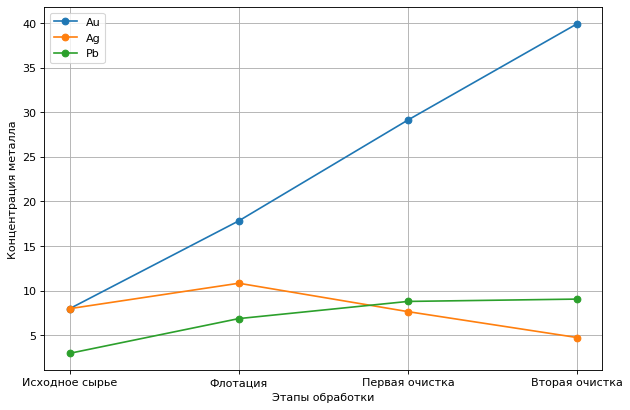

In [14]:
au_1 = df_full['rougher.input.feed_au'].mean()
au_2 = df_full['rougher.output.concentrate_au'].mean()
au_3 = df_full['primary_cleaner.output.concentrate_au'].mean()
au_4 = df_full['final.output.concentrate_au'].mean()

ag_1 = df_full['rougher.input.feed_ag'].mean()
ag_2 = df_full['rougher.output.concentrate_ag'].mean()
ag_3 = df_full['primary_cleaner.output.concentrate_ag'].mean()
ag_4 = df_full['final.output.concentrate_ag'].mean()

pb_1 = df_full['rougher.input.feed_pb'].mean()
pb_2 = df_full['rougher.output.concentrate_pb'].mean()
pb_3 = df_full['primary_cleaner.output.concentrate_pb'].mean()
pb_4 = df_full['final.output.concentrate_pb'].mean()

concentration_index = pd.Series(['Исходное сырье', 'Флотация', 'Первая очистка', 'Вторая очистка'])
concentration_data = {'Au': [round(au_1,0), round(au_2,3), round(au_3,3), round(au_4,3)],\
                 'Ag': [round(ag_1,0), round(ag_2,3), round(ag_3,3), round(ag_4,3)],\
                 'Pb': [round(pb_1,0), round(pb_2,3), round(pb_3,3), round(pb_4,3)]}

concentration_df = pd.DataFrame(data = concentration_data).set_index(concentration_index)
print('Концентрация металлов на разных стадиях обработки')
display(concentration_df)

plt.figure(num=None, figsize=(9, 6), dpi=80, facecolor='w', edgecolor='k')

for metal in concentration_df.columns:
    plt.plot(concentration_df.index.tolist(), concentration_df.loc[:, metal], 'o-')
    
plt.legend(concentration_df.columns)
plt.grid()
plt.xlabel('Этапы обработки')
plt.ylabel('Концентрация металла')
plt.show()

*Концентрация золота повышается с каждым этапом. Цель флотации и очисток увеличить концентрацию золота.  
Конецентрация серебра возрастает после флотации, а на последующих этапах понижается с каждым шагом очистки. Концентрация свинца не значительно повышается до этапа первой очистки, затем усредняется. Так как основным благородным металом является золото, то остальные металлы и соединения должны быть отфильтрованы.*

* Сравним распределения размеров гранул сырья на обучающей и тестовой выборках

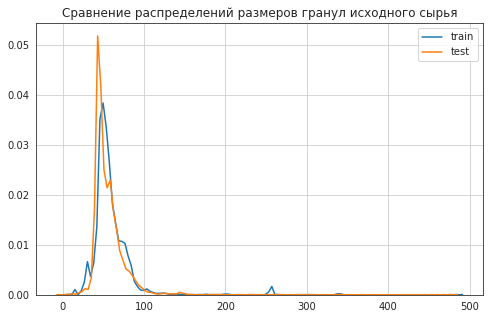

In [15]:
fig = plt.figure(figsize=(8, 5))

rougher_size_train = df_train['rougher.input.feed_size']
rougher_size_test = df_test['rougher.input.feed_size']

with sns.axes_style("white"):
    sns.kdeplot(rougher_size_train)
    sns.kdeplot(rougher_size_test)
    plt.legend(['train', 'test'])
    plt.grid()
    plt.title('Сравнение распределений размеров гранул исходного сырья')


<div class="alert alert-warning">
<h1>Комментарий ревьюера <a class="tocSkip"></a></h1>
Стоило еще посмотреть на форму графиков без хвостов (выбросов)</div>

Визуально распределения очень похожи.

Проверим гипотезу о равенстве двух средних генеральных совокупностей.

In [16]:
# Сравним дисперсии выборок
rougher_size_train_var = np.var(rougher_size_train, ddof=1)
rougher_size_test_var = np.var(rougher_size_test, ddof=1)

print('Дисперсия rougher_size_train:', round(rougher_size_train_var, 2))
print('Дисперсия rougher_size_test:', round(rougher_size_test_var, 2))

Дисперсия rougher_size_train: 931.61
Дисперсия rougher_size_test: 515.65


Дисперсии выборок не равны, поэтому зададим аргумент equal_var = False. Уровень значимости примем 5%.

In [17]:
alpha = 0.05
results = st.ttest_ind(rougher_size_train, rougher_size_test, equal_var=False)
if (results.pvalue < alpha):
    print("Распределения размеров гранул в двух выборках не отличаются")
else:
    print("Распределения размеров гранул в двух выборках отличаются")

Распределения размеров гранул в двух выборках не отличаются


* Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

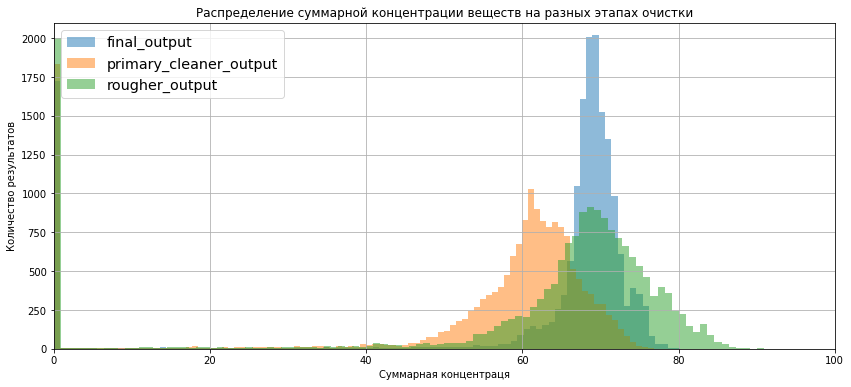

In [18]:
# Вычислим суммарную концентрацию
final_output_concentrate_sum_train = (df_train['final.output.concentrate_au'] + 
                                      df_train['final.output.concentrate_ag'] + 
                                      df_train['final.output.concentrate_pb'] +
                                      df_train['final.output.concentrate_sol'])
primary_cleaner_output_concentrate_sum_train = (df_train['primary_cleaner.output.concentrate_au'] + 
                                                df_train['primary_cleaner.output.concentrate_ag'] + 
                                                df_train['primary_cleaner.output.concentrate_pb'] +
                                                df_train['primary_cleaner.output.concentrate_sol'])
rougher_output_concentrate_sum_train = (df_train['rougher.output.concentrate_au'] + 
                                        df_train['rougher.output.concentrate_ag'] + 
                                        df_train['rougher.output.concentrate_pb'] +
                                        df_train['rougher.output.concentrate_sol'])

# Отобразим значения на графике
plt.figure(figsize=[14,6])

plt.hist(final_output_concentrate_sum_train, bins=100, label = 'final_output', alpha=.5)
plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'primary_cleaner_output', alpha=.5)
plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'rougher_output', alpha=.5)

plt.xlim([0, 100])
plt.ylim([0, 2100])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("Распределение суммарной концентрации веществ на разных этапах очистки")
plt.grid()
plt.show()

При анализе суммарной концентрации металлов на разных стадиях, мы видим что имеется большое количество нулевых значений. Пик нулевых значений очень далек от общего распределения, его следует удалить. 

In [19]:
# Создадим список из названия процессов производства
processes = ['rougher.input.feed_', 
             'rougher.output.concentrate_', 
             'primary_cleaner.output.concentrate_', 
             'final.output.concentrate_']

# Отдельно выделим тип металлов, чтобы потом соединить их с производственными процессами
metals = ['au', 'pb', 'ag']

# Удалим из обучающей и тестовой выборки нулевые значения
for process in processes:
    for metal in metals:
        df_train = df_train.loc[df_train[process+metal] != 0]
        if process==processes[0]:
            df_test = df_test.loc[df_test[process+metal] != 0]

Посмотрим на получившиеся размеры датасетов

In [20]:
df_train.shape, df_test.shape

((14973, 86), (5485, 52))

Размеры выборок сократились. Взглянем ещё раз на суммарную концентрацию веществ

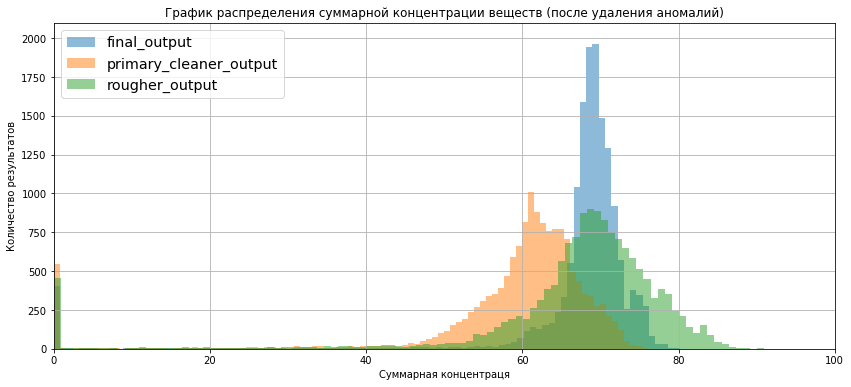

In [21]:
# Вычислим суммарную концентрацию
final_output_concentrate_sum_train = (df_train['final.output.concentrate_au'] + 
                                      df_train['final.output.concentrate_ag'] + 
                                      df_train['final.output.concentrate_pb'] +
                                      df_train['final.output.concentrate_sol'])
primary_cleaner_output_concentrate_sum_train = (df_train['primary_cleaner.output.concentrate_au'] + 
                                                df_train['primary_cleaner.output.concentrate_ag'] + 
                                                df_train['primary_cleaner.output.concentrate_pb'] +
                                                df_train['primary_cleaner.output.concentrate_sol'])
rougher_output_concentrate_sum_train = (df_train['rougher.output.concentrate_au'] + 
                                        df_train['rougher.output.concentrate_ag'] + 
                                        df_train['rougher.output.concentrate_pb'] +
                                        df_train['rougher.output.concentrate_sol'])

# Отобразим значения на графике
plt.figure(figsize=[14,6])

plt.hist(final_output_concentrate_sum_train, bins=100, label = 'final_output', alpha=.5)
plt.hist(primary_cleaner_output_concentrate_sum_train, bins=100, label = 'primary_cleaner_output', alpha=.5)
plt.hist(rougher_output_concentrate_sum_train, bins=100, label = 'rougher_output', alpha=.5)

plt.xlim([0, 100])
plt.ylim([0, 2100])

plt.xlabel("Суммарная концентраця")
plt.ylabel("Количество результатов")

plt.legend(loc='upper left', fontsize='x-large')

plt.title("График распределения суммарной концентрации веществ (после удаления аномалий)")
plt.grid()
plt.show()

Видим, что количество нулевых значений значительно сократилось.  
Оставшиеся значения, близкие к 0, оставим без изменений, так как неизвестна их природа, возможно, они часть реального производственного процесса.

## Модель

* Напишем функцию для вычисления sMAPE и итоговой sMAPE

In [22]:
def smape(target, pred):
    return 1/len(target) * np.sum(2 * np.abs(target - pred) / (np.abs(target) + np.abs(pred))*100)

In [23]:
def smape_final(rougher, final):
    return 0.25 * rougher + 0.75 * final

In [24]:
scorer = make_scorer(smape, greater_is_better=True)

Разделим данные на target и features, а так же масштабируем признаки.

In [25]:
features = df_test.columns.values
features_train = df_train[features].reset_index(drop=True)
features_test = df_test

target_train_r = df_train['rougher.output.recovery']
target_train_f = df_train['final.output.recovery']

In [26]:
scaler = StandardScaler()
scaler.fit(features_train)

features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

* Обучим модели и оценим их качество кросс-валидацией

**DecisionTreeRegressor**

In [27]:
sMAPE_best = 100
for depth in tqdm(range(2, 10)):
    model_one = DecisionTreeRegressor(random_state=42, max_depth=depth)
    cvs_r = cross_val_score(model_one, features_train, target_train_r, scoring=scorer, cv=5).mean()
    cvs_f = cross_val_score(model_one, features_train, target_train_f, scoring=scorer, cv=5).mean()
    sMAPE = smape_final(cvs_r,cvs_f)
    if sMAPE < sMAPE_best:
        sMAPE_best = round(sMAPE, 3)
        best_depth = depth
print('Итоговое sMAPE', sMAPE_best, 'при max_depth =', best_depth)


Итоговое sMAPE 10.053 при max_depth = 2


**RandomForestRegressor**

In [28]:
sMAPE_best = 100
for depth in tqdm(range(2, 10)):
    for est in range(2, 10):
        model_two = RandomForestRegressor(random_state=42, max_depth=depth, n_estimators=est)
        cvs_r = cross_val_score(model_two, features_train, target_train_r, scoring=scorer, cv=5).mean()
        cvs_f = cross_val_score(model_two, features_train, target_train_f, scoring=scorer, cv=5).mean()
        sMAPE = smape_final(cvs_r,cvs_f)
        if sMAPE < sMAPE_best:
            sMAPE_best = round(sMAPE, 3)
            best_depth = depth
            best_est = est
print('Итоговое sMAPE', sMAPE_best, "при max_depth =", best_depth, "и n_estimators =", best_est)  


Итоговое sMAPE 9.648 при max_depth = 5 и n_estimators = 9


**LinearRegression**

In [29]:
model_three = LinearRegression()

cvs_r = cross_val_score(model_three, features_train, target_train_r, scoring=scorer, cv=5).mean()
cvs_f = cross_val_score(model_three, features_train, target_train_f, scoring=scorer, cv=5).mean()
sMAPE = smape_final(cvs_r,cvs_f)
print('Итоговое sMAPE', round(sMAPE, 3)) 

Итоговое sMAPE 11.826


In [30]:
model_three_normalized = LinearRegression(normalize=True)

cvs_r = cross_val_score(model_three_normalized, features_train, target_train_r, scoring=scorer, cv=5).mean()
cvs_f = cross_val_score(model_three_normalized, features_train, target_train_f, scoring=scorer, cv=5).mean()
sMAPE = smape_final(cvs_r,cvs_f)
print('Итоговое sMAPE', round(sMAPE, 3))

Итоговое sMAPE 11.826


**CatBoostRegressor**

In [31]:
cat_model = CatBoostRegressor(iterations=300, verbose=100, early_stopping_rounds=100, random_state=42)

cvs_r = cross_val_score(cat_model, features_train, target_train_r, scoring=scorer, cv=5).mean()
cvs_f = cross_val_score(cat_model, features_train, target_train_f, scoring=scorer, cv=5).mean()
sMAPE = smape_final(cvs_r,cvs_f)
print('Итоговое sMAPE', round(sMAPE, 3))

0:	learn: 9.2776877	total: 57.6ms	remaining: 17.2s
100:	learn: 6.2874588	total: 7.95s	remaining: 15.7s
200:	learn: 5.6945647	total: 15.4s	remaining: 7.58s
299:	learn: 5.3169242	total: 22.7s	remaining: 0us
0:	learn: 9.6937337	total: 16.9ms	remaining: 5.04s
100:	learn: 6.5812268	total: 7.93s	remaining: 15.6s
200:	learn: 5.9527793	total: 15.5s	remaining: 7.62s
299:	learn: 5.5545354	total: 23.1s	remaining: 0us
0:	learn: 9.8062380	total: 21.5ms	remaining: 6.42s
100:	learn: 6.3392501	total: 7.84s	remaining: 15.4s
200:	learn: 5.6938612	total: 15.6s	remaining: 7.67s
299:	learn: 5.2958303	total: 23.6s	remaining: 0us
0:	learn: 9.2215080	total: 8.57ms	remaining: 2.56s
100:	learn: 6.0967029	total: 7.71s	remaining: 15.2s
200:	learn: 5.5155072	total: 15.1s	remaining: 7.46s
299:	learn: 5.1480391	total: 22.3s	remaining: 0us
0:	learn: 9.3446765	total: 12.5ms	remaining: 3.74s
100:	learn: 6.3923109	total: 7.56s	remaining: 14.9s
200:	learn: 5.8455701	total: 15s	remaining: 7.39s
299:	learn: 5.4457130	total

**Из всех моделей CatBoostRegressor показал наилучший результат.**

* Используем модель CatBoostRegressor для обучения и проверим её на тестовой выборке.

In [32]:
cat_model_r = CatBoostRegressor(iterations=300, verbose=100, early_stopping_rounds=100, random_state=42)
cat_model_r.fit(features_train, target_train_r)
predicted_r = cat_model_r.predict(features_test)
predicted_r

0:	learn: 9.5098032	total: 9.77ms	remaining: 2.92s
100:	learn: 6.4657511	total: 8.01s	remaining: 15.8s
200:	learn: 5.9019544	total: 15.9s	remaining: 7.83s
299:	learn: 5.5310078	total: 23.6s	remaining: 0us


array([86.58639165, 86.26339545, 86.54632566, ..., 91.16419199,
       91.31852286, 91.22247986])

In [33]:
cat_model_f = CatBoostRegressor(iterations=300, verbose=100,early_stopping_rounds=100, random_state=12345)
cat_model_f.fit(features_train, target_train_f)
predicted_f = cat_model_f.predict(features_test)
predicted_f

0:	learn: 10.9839062	total: 8.42ms	remaining: 2.52s
100:	learn: 7.5822953	total: 7.77s	remaining: 15.3s
200:	learn: 7.0200999	total: 15.5s	remaining: 7.63s
299:	learn: 6.6601177	total: 23.4s	remaining: 0us


array([68.03406058, 67.54198279, 67.47493174, ..., 72.082989  ,
       72.51258082, 72.84842878])

Возьмем из полного датафрейма значения 'rougher.output.recovery' и 'final.output.recovery' для того, что бы узнать sMAPE

In [34]:
target_test_df_r = df_full[df_full.index.isin(df_test.index)]['rougher.output.recovery']
target_test_df_f = df_full[df_full.index.isin(df_test.index)]['final.output.recovery']

Подсчитаем итоговую sMAPE для тестовой выборки

In [35]:
r_smape = smape(target_test_df_r, predicted_r)
f_smape = smape(target_test_df_f, predicted_f)
print('Значение итоговой sMAPE для тестовой выборки:', round(smape_final(r_smape, f_smape), 3))

Значение итоговой sMAPE для тестовой выборки: 10.022


* Сделаем сравнение нашей модели с константными моделями

In [36]:
const_mean = DummyRegressor(strategy="mean")
const_median = DummyRegressor(strategy="median")

In [37]:
const_mean.fit(features_train, target_train_r)
preds_rough = const_mean.predict(features_test)
const_mean.fit(features_train, target_train_f)
preds_final = const_mean.predict(features_test)

r_smape = smape(target_test_df_r, preds_rough)
f_smape = smape(target_test_df_f, preds_final)

print('Значение итоговой sMAPE по константному среднему:', round(smape_final(r_smape, f_smape), 3))

Значение итоговой sMAPE по константному среднему: 10.727


In [38]:
const_median.fit(features_train, target_train_r)
preds_rough = const_median.predict(features_test)
const_median.fit(features_train, target_train_f)
preds_final = const_median.predict(features_test)

r_smape = smape(target_test_df_r, preds_rough)
f_smape = smape(target_test_df_f, preds_final)

print('Значение итоговой sMAPE по константному медианному:', round(smape_final(r_smape, f_smape), 3))

Значение итоговой sMAPE по константному медианному: 10.504


*Значение итоговой sMAPE у константной модели получилось хуже, чем у выбранной нами. Следовательно наша модель лучше константной.*

In [40]:
smape_final_index = pd.Series(['DecisionTree', 'RandomForest', 'LinearRegression', 'CatBoost', 
                               'CatBoost (тест)', 'const_mean', 'const_median'])
smape_final_data = {'Итоговая sMAPE': [10.053, 9.648, 11.826, 9.606, 10.022, 10.727, 10.504]}

smape_final_df = pd.DataFrame(data = smape_final_data).set_index(smape_final_index)
print('Значение итоговой sMAPE у разных моделей')
display(smape_final_df)

Значение итоговой sMAPE у разных моделей


,Итоговая sMAPE
DecisionTree,10.053
RandomForest,9.648
LinearRegression,11.826
CatBoost,9.606
CatBoost (тест),10.022
const_mean,10.727
const_median,10.504


## Общий вывод

В начале проекта мы проанализировали и обработали исходные данные. Далее, на основе обучающей выборки были построены модели: дерева решений, случайного леса, линейной регрессии и CatBoost. Качество моделей было проверено кросс-валидацией. Наилучшее значение целевой метрики показала модель **CatBoostRegressor**, со значением итоговой sМАРЕ 9.606.

При проверке модели на тестовой выборке значение метрики ухудшилось. **Итоговое отклонение sМАРЕ составило 10.022**, что свидетельствует о небольшом переобучении модели.